In [21]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



In [22]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for dat pre-processing

In [23]:
from imblearn.over_sampling import SMOTE
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)   

        return df

In [24]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [25]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Multi')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

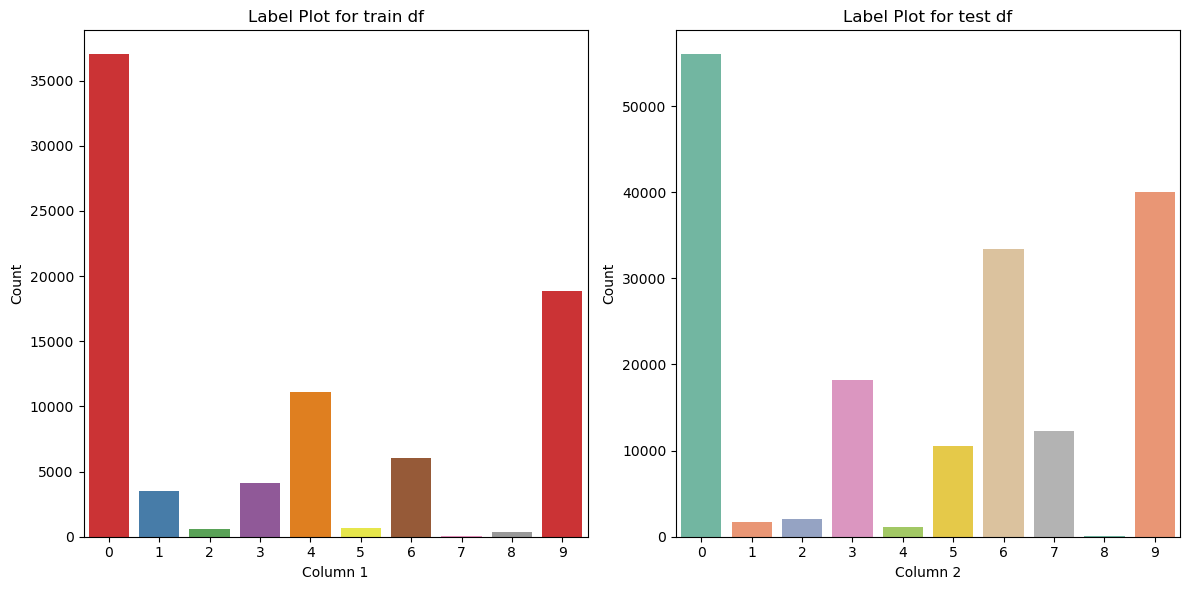

In [26]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [27]:
combined_df = pd.concat([train_df, test_df])
shuffled_df = combined_df.sample(frac=1, random_state=42)
split_ratio = 0.8
split_index = int(len(shuffled_df) * split_ratio)

train_df = shuffled_df[:split_index]
test_df = shuffled_df[split_index:]

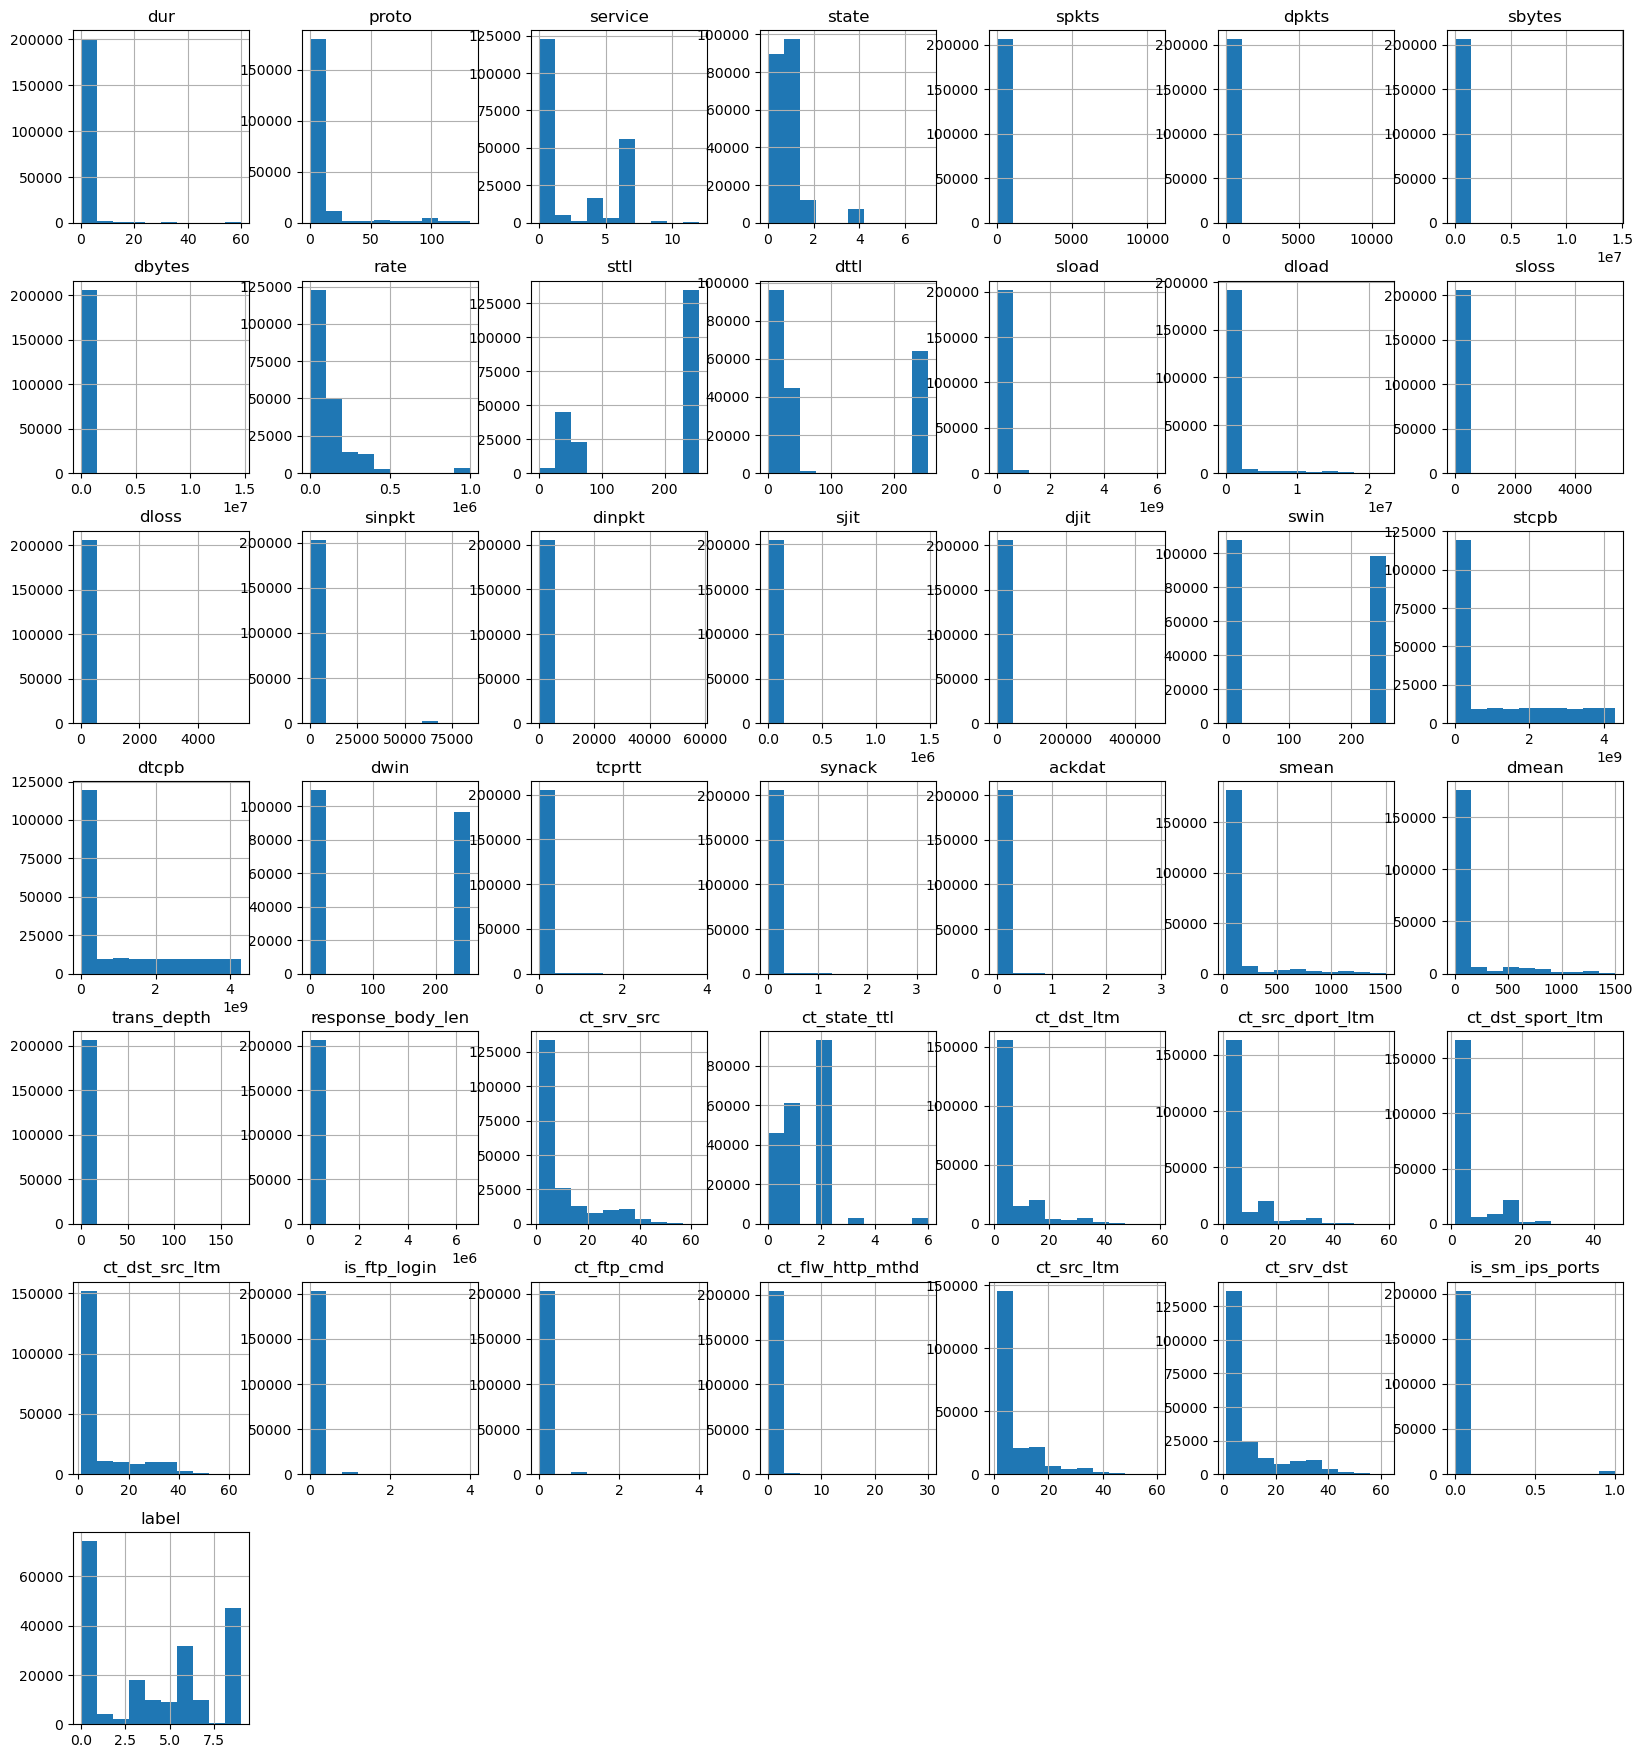

In [28]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

### Correlation matrix

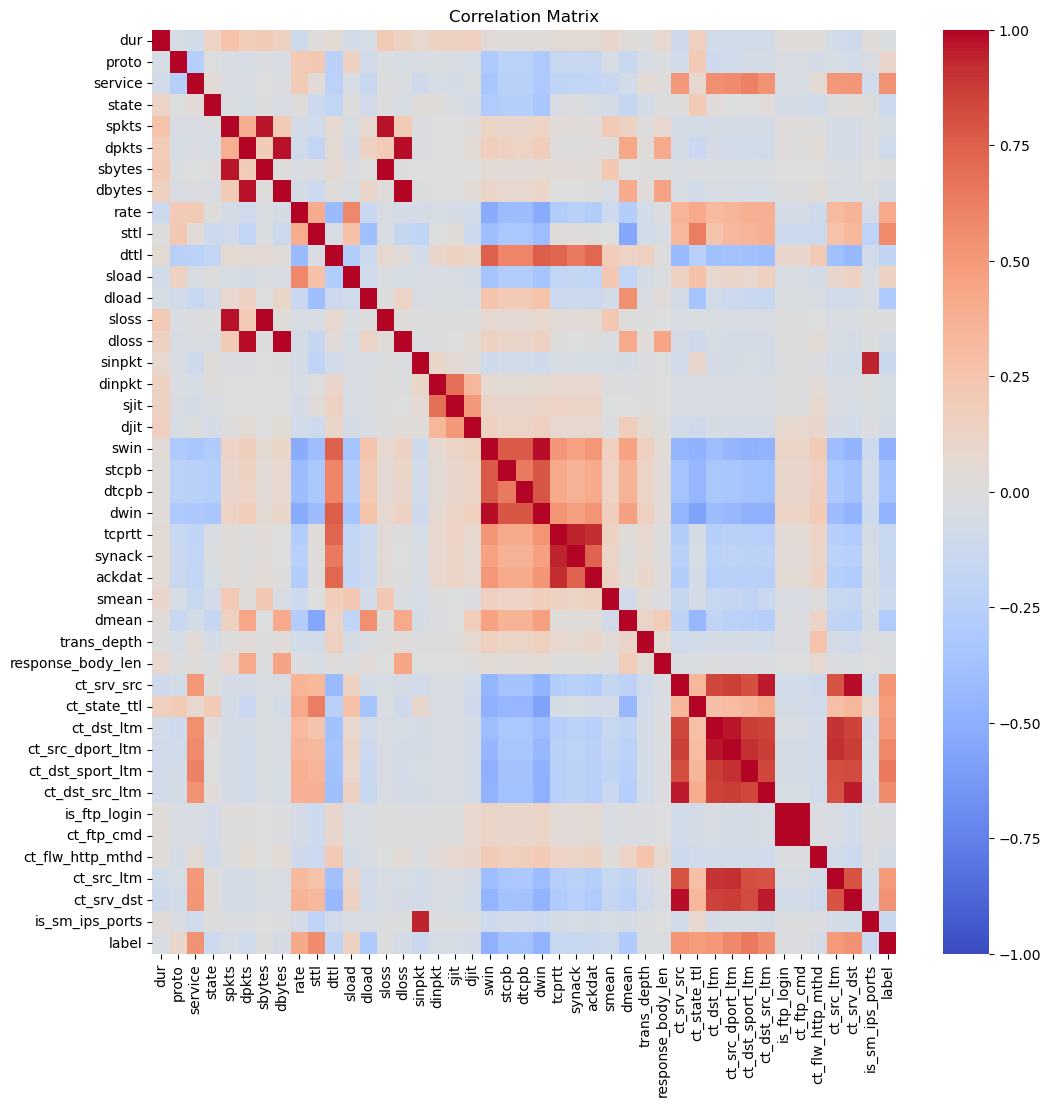

In [29]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [30]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in sorted_corr.items():
    print(f"{attribute}: {correlation:.4f}")

label: 1.0000
ct_dst_sport_ltm: 0.6490
ct_src_dport_ltm: 0.5842
sttl: 0.5660
ct_dst_src_ltm: 0.5656
service: 0.5346
ct_srv_dst: 0.5344
ct_srv_src: 0.5264
ct_dst_ltm: 0.5149
ct_src_ltm: 0.4942
swin: 0.4907
ct_state_ttl: 0.4853
dwin: 0.4689
rate: 0.4183
stcpb: 0.3678
dtcpb: 0.3665
dload: 0.2984
dmean: 0.2930
dttl: 0.1891
tcprtt: 0.1534
synack: 0.1517
sload: 0.1392
sinpkt: 0.1358
is_sm_ips_ports: 0.1344
ackdat: 0.1331
state: 0.1299
smean: 0.1178
dpkts: 0.0980
proto: 0.0895
dloss: 0.0743
djit: 0.0673
ct_flw_http_mthd: 0.0602
dbytes: 0.0577
spkts: 0.0534
sjit: 0.0499
dinpkt: 0.0497
dur: 0.0312
trans_depth: 0.0257
ct_ftp_cmd: 0.0224
is_ftp_login: 0.0222
response_body_len: 0.0171
sloss: 0.0119
sbytes: 0.0055


In [31]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

In [32]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [33]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [34]:
# Pipeline example
pipeline = SparkDFPipeline(standardize=False)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

In [35]:
train.show()

23/08/15 17:40:06 WARN TaskSetManager: Stage 108 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(42,[0,3,4,5,6,7,...|    0|
|(42,[0,2,4,6,8,9,...|    9|
|(42,[1,3,4,6,15,2...|    0|
|(42,[0,1,3,4,6,8,...|    7|
|(42,[0,2,4,6,8,9,...|    9|
|[0.709178,0.0,0.0...|    4|
|[0.922491,0.0,0.0...|    3|
|(42,[0,1,2,3,4,5,...|    0|
|[0.216048,2.0,0.0...|    9|
|[0.026845,0.0,1.0...|    0|
|[1.774297,0.0,2.0...|    6|
|(42,[0,1,3,4,6,8,...|    6|
|[0.004561,2.0,0.0...|    0|
|(42,[0,1,2,3,4,6,...|    9|
|(42,[0,1,2,3,4,6,...|    9|
|(42,[0,1,3,4,6,8,...|    7|
|(42,[0,1,3,4,6,8,...|    7|
|(42,[0,2,4,6,8,9,...|    9|
|(42,[0,1,3,4,6,8,...|    6|
|(42,[0,1,2,3,4,6,...|    9|
+--------------------+-----+
only showing top 20 rows



## Generate the weight for features

In [36]:

# Calculate class frequencies
class_frequencies = train.groupBy("label").count()

# Calculate class weights
total_samples = train.count()
class_frequencies = class_frequencies.withColumn("weight", total_samples / (class_frequencies["count"] * class_frequencies.count()))

# Join the weights with the training data
train_with_weights = train.join(class_frequencies, on="label")

23/08/15 17:40:09 WARN TaskSetManager: Stage 111 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:11 WARN TaskSetManager: Stage 117 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.


## NB Model

In [37]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features", labelCol="label", weightCol="weight")
# nb = NaiveBayes(featuresCol="features", labelCol="label")

nb_model = nb.fit(train_with_weights)
# nb_model = nb.fit(train)

23/08/15 17:40:16 WARN TaskSetManager: Stage 127 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:17 WARN TaskSetManager: Stage 128 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:24 WARN TaskSetManager: Stage 133 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:26 WARN TaskSetManager: Stage 134 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.


In [38]:
# Make prediction 

predictions = nb_model.transform(test)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(predictions)
print("Area under PR = %g" % pr_score)

23/08/15 17:40:36 WARN TaskSetManager: Stage 145 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.533637333850781


23/08/15 17:40:37 WARN TaskSetManager: Stage 147 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under ROC = 0.755787


23/08/15 17:40:38 WARN TaskSetManager: Stage 158 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under PR = 0.845449


### Fine tune NB Model

In [39]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql import SparkSession

# Create a NaiveBayes instance
nb = NaiveBayes(featuresCol="features", labelCol="label", weightCol="weight")
# nb = NaiveBayes(featuresCol="features", labelCol="label")


# Create a grid of parameters to search through
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.01, 0.1, 0.5, 1.0]) \
    .build()

# Create an evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Set up the TrainValidationSplit with cross-validation
tvs = TrainValidationSplit(estimator=nb,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)  # 80% of the data will be used for training

# Fit the model using the TrainValidationSplit
tvs_model = tvs.fit(train_with_weights)

# Get the best NaiveBayes model from the grid search
best_nb_model = tvs_model.bestModel

23/08/15 17:40:40 WARN TaskSetManager: Stage 173 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:42 WARN TaskSetManager: Stage 172 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:52 WARN TaskSetManager: Stage 184 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:40:52 WARN TaskSetManager: Stage 183 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:41:06 WARN TaskSetManager: Stage 257 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:41:07 WARN TaskSetManager: Stage 258 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:41:13 WARN TaskSetManager: Stage 263 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.

In [40]:
# Make prediction 

predictions = best_nb_model.transform(test)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(predictions)
print("Area under PR = %g" % pr_score)

23/08/15 17:41:20 WARN TaskSetManager: Stage 276 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.5350732511885127


23/08/15 17:41:21 WARN TaskSetManager: Stage 278 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under ROC = 0.756525


23/08/15 17:41:22 WARN TaskSetManager: Stage 289 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under PR = 0.846025


In [41]:
spark.stop()